# How to convert a Tagtog project to Kili

## Setup

In [ ]:
%pip install kili rich beautifulsoup4

In [ ]:
from kili.client import Kili
from pathlib import Path
from rich import print_json
import pprint
from bs4 import BeautifulSoup
import json
import os

In [ ]:
kili = Kili()

## Get data

For this recipe, we will use data from the [Apartment reviews](https://tagtog.com/JaqenNLP/ApartmentReviews) project made by Jennifer D. Ames.

The dataset consists in guests' reviews of apartments/houses for short-term lodging and tourism-related activities.

The reviews have been obtained from Inside Airbnb.

Each review has been manually annotated in tagtog.

Let's download the project data (you will need to be logged in tagtog to do so) by clicking this [link](https://tagtog.com/JaqenNLP/ApartmentReviews/-downloads/dataset-as-anndoc).

Once the .zip file is downloaded, we can unzip it:

In [ ]:
!tar -xvf tagtog_ApartmentReviews.zip

In [ ]:
print(Path("ApartmentReviews/README.md").read_text(encoding="utf-8"))

This dataset lives in: https://tagtog.com/JaqenNLP/ApartmentReviews

This zip was generated with:
  * date: _2023-05-10T11:25:54.902Z_
  * search: `*`
  * total found documents: **228**

The dataset is here written in the [anndoc format](https://docs.tagtog.com/anndoc.html). Use the `annotations-legend.json` file to help you interpret the annotations.


What great things will you do with the dataset? :-) Enjoy!



Let's take a look at the ontology:

In [ ]:
tagtog_class_id_to_class_name = json.loads(
    Path("ApartmentReviews/annotations-legend.json").read_text(encoding="utf-8")
)
pprint.pprint(tagtog_class_id_to_class_name)

{'e_1': 'Loyalty',
 'e_13': 'TechOpinion',
 'e_14': 'FoodOpinion',
 'e_2': 'RoomOpinion',
 'e_4': 'ApartmentOpinion',
 'e_5': 'Location',
 'e_6': 'KitchenOpinion',
 'e_7': 'BathroomOpinion',
 'e_8': 'HostOpinion',
 'e_9': 'PricePayment',
 'f_10': 'RoomItem',
 'f_11': 'OutdoorFeature',
 'f_12': 'BathroomFeature',
 'f_15': 'TechFeature',
 'f_16': 'FoodFeature',
 'f_17': 'LocationFeature',
 'f_19': 'LoyaltyFeature',
 'f_20': 'ApartmentFeature',
 'f_21': 'HostCharacter',
 'f_22': 'isLocationQuiet',
 'f_23': 'Sentiment',
 'f_24': 'isCriticalProblem',
 'f_25': 'KitchenFeature',
 'f_26': 'PaymentFeature',
 'm_18': 'Sentiment'}


The ontology shows:

- 10 entity types (keys starting with `e_`)

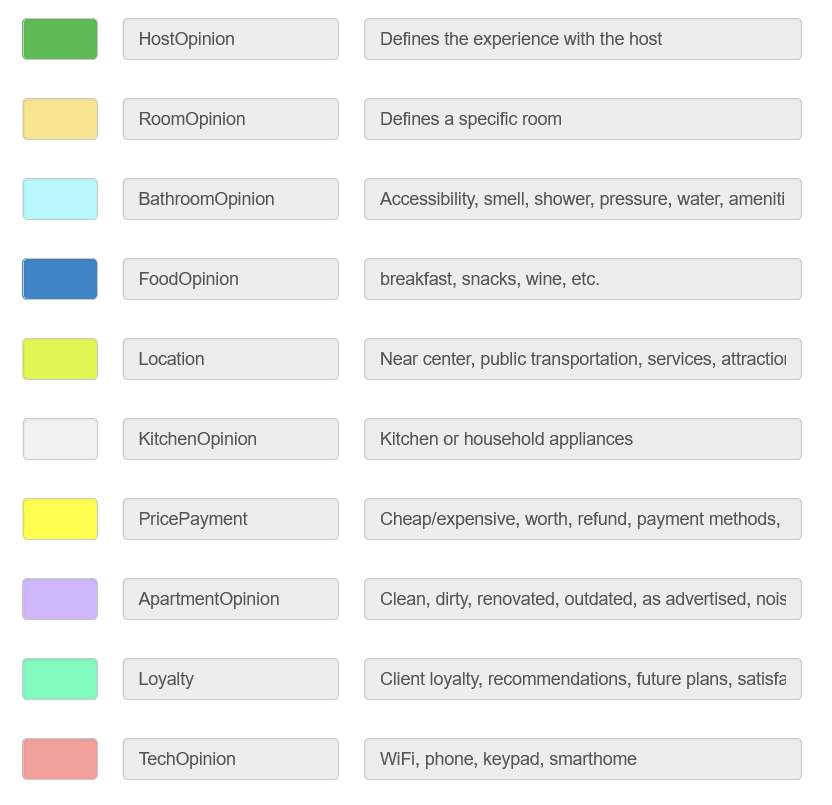

- 1 document label (key starting with `m_`)

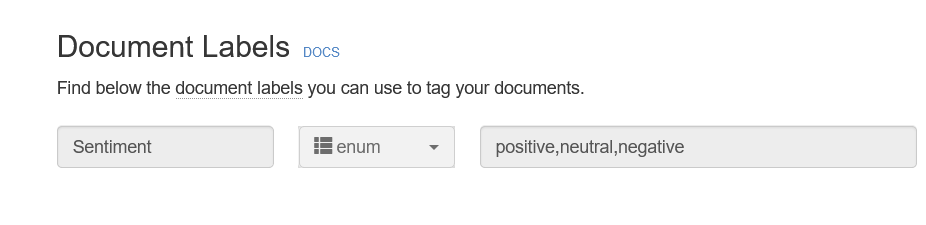

- 14 entity labels (keys starting with `f_`)

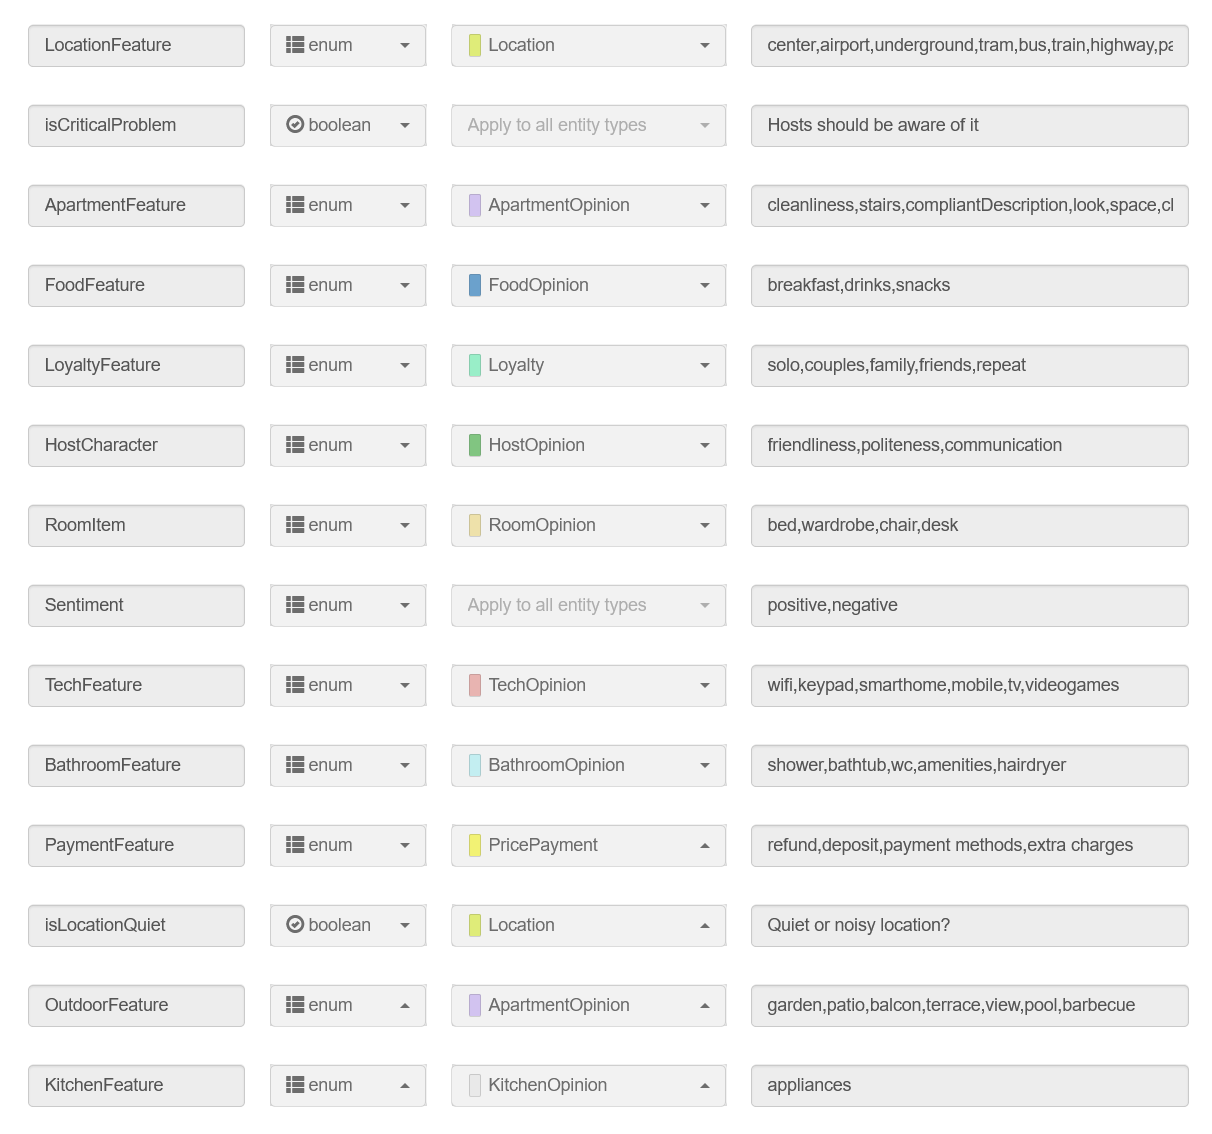

An entity label is used to tag an entity type, and aims at giving more information about the entity being annotated. For example, the `"f_17": "LocationFeature"` label can be used to tag a `"e_5": "Location"` entity type.



Read more about this project ontology [here](https://tagtog.com/JaqenNLP/ApartmentReviews/-settings).

The `plain.html/pool` folder contains the reviews in HTML format:

In [ ]:
print(
    Path("ApartmentReviews/plain.html/pool/a.km05GoV2Uh1mw9QR.UNiNXWUL8-text.plain.html").read_text(
        encoding="utf-8"
    )
)

<!DOCTYPE html >
<html id="a.km05GoV2Uh1mw9QR.UNiNXWUL8-text" data-origid="text" class="anndoc" data-anndoc-version="3.6" lang="" xml:lang="" xmlns="http://www.w3.org/1999/xhtml">
  <head>
    <meta charset="UTF-8"/>
    <meta name="generator" content="net.tagtog.anndoc.v3.parsers.general.PlainTextParser_NewParagraphAfter1Newline_v2_0_0"/>
    <title>a.km05GoV2Uh1mw9QR.UNiNXWUL8-text</title>
  </head>
  <body>
    <article>
      <section data-type="">
        <div class="content">
          <p id="s1p1">The house is beautiful, but it is next to 2 very busy roads. There are no aircons in any rooms and to open the windows you hear the cars and trucks pass - very loud. There is no braai facilities and when we asked x 2 we were told the owner had to approve... still waiting! The rooms on the lower floor is empty and depressing, very hot! Kids slept on couches with sliding doors open, so we could not arm the alarm at night. The aircons on the upper level leaks water onto table and electric

The annotations are stored in the folder `ann.json/master/pool`:

In [ ]:
annotation_sample = json.loads(
    Path(
        "ApartmentReviews/ann.json/master/pool/a.km05GoV2Uh1mw9QR.UNiNXWUL8-text.ann.json"
    ).read_text(encoding="utf-8")
)
# select only two entities for visualization
annotation_sample["entities"] = annotation_sample["entities"][:2]
pprint.pprint(annotation_sample)

{'anncomplete': True,
 'annotatable': {'parts': ['s1p1']},
 'entities': [{'classId': 'e_4',
               'confidence': {'prob': 1,
                              'state': 'pre-added',
                              'who': ['user:Mrdenho']},
               'coordinates': [],
               'fields': {'f_23': {'confidence': {'prob': 1,
                                                  'state': 'pre-added',
                                                  'who': ['user:Mrdenho']},
                                   'value': 'positive'}},
               'normalizations': {},
               'offsets': [{'start': 0, 'text': 'The house is beautiful'}],
               'part': 's1p1'},
              {'classId': 'e_5',
               'confidence': {'prob': 1,
                              'state': 'pre-added',
                              'who': ['user:Mrdenho']},
               'coordinates': [],
               'fields': {'f_22': {'confidence': {'prob': 1,
                                    

## Create the Kili project

We can start creating the Named Entity Recognition (NER) Kili project.

To do so, we will need to define a json interface that follows the ontology of the `annotations-legend.json` file.

Note that with Kili, the json interface can be created directly from the [Kili UI](https://docs.kili-technology.com/docs/customizing-project-interface).

Here, we will use a `json_interface` variable that will be passed to `kili.create_project()`.

We have two main jobs:

- `SENTIMENT_CLASSIFICATION_JOB` for classifying the review as positive, negative or neutral
- `NAMED_ENTITIES_RECOGNITION_JOB` for the entity type.

We also have several child jobs representing the entity labels.

In [ ]:
# fmt: off
json_interface = {
    "jobs": {
        "SENTIMENT_CLASSIFICATION_JOB": {
            "content": {
                "categories": {
                    "positive": {"children": [], "name": "positive"},
                    "neutral": {"children": [], "name": "neutral"},
                    "negative": {"children": [], "name": "negative"},
                },
                "input": "radio",
            },
            "instruction": "Sentiment",
            "mlTask": "CLASSIFICATION",
            "required": 0,
            "isChild": False,
        },
        "NAMED_ENTITIES_RECOGNITION_JOB": {
            "content": {
                "categories": {
                    "HostOpinion": {
                        "children": ["isCriticalProblem", "HostCharacter", "Sentiment"],
                        "color": "#472CED",
                        "name": "HostOpinion",
                    },
                    "RoomOpinion": {
                        "children": ["isCriticalProblem", "RoomItem", "Sentiment"],
                        "name": "RoomOpinion",
                        "color": "#5CE7B7",
                    },
                    "BathroomOpinion": {
                        "children": ["isCriticalProblem", "Sentiment", "BathroomFeature"],
                        "name": "BathroomOpinion",
                        "color": "#D33BCE",
                    },
                    "FoodOpinion": {
                        "children": ["isCriticalProblem", "FoodFeature", "Sentiment"],
                        "name": "FoodOpinion",
                        "color": "#FB753C",
                    },
                    "Location": {
                        "children": ["LocationFeature", "isCriticalProblem", "Sentiment", "isLocationQuiet"],
                        "name": "Location",
                        "color": "#3BCADB"
                    },
                    "KitchenOpinion": {
                        "children": ["isCriticalProblem", "Sentiment", "KitchenFeature"],
                        "name": "KitchenOpinion",
                        "color": "#199CFC",
                    },
                    "PricePayment": {
                        "children": ["isCriticalProblem", "Sentiment", "PaymentFeature"],
                        "name": "PricePayment",
                        "color": "#FA484A",
                    },
                    "ApartmentOpinion": {
                        "children": ["isCriticalProblem", "ApartmentFeature", "Sentiment", "KitchenFeature"],
                        "name": "ApartmentOpinion",
                        "color": "#ECB82A"
                    },
                    "Loyalty": {
                        "children": ["isCriticalProblem", "LoyaltyFeature", "Sentiment"],
                        "name": "Loyalty",
                        "color": "#3CD876",
                    },
                    "TechOpinion": {
                        "children": ["isCriticalProblem", "Sentiment", "TechFeature"],
                        "name": "TechOpinion",
                        "color": "#733AFB",
                    },
                },
                "input": "radio",
            },
            "instruction": "Entity type",
            "mlTask": "NAMED_ENTITIES_RECOGNITION",
            "required": 1,
            "isChild": False,
        },
        "LocationFeature": {
            "content": {
                "categories": {
                    "center": {"children": [], "name": "center"},
                    "airport": {"children": [], "name": "airport"},
                    "underground": {"children": [], "name": "underground"},
                    "tram": {"children": [], "name": "tram"},
                    "bus": {"children": [], "name": "bus"},
                    "train": {"children": [], "name": "train"},
                    "highway": {"children": [], "name": "highway"},
                    "parking": {"children": [], "name": "parking"},
                    "shopping": {"children": [], "name": "shopping"},
                    "tourism": {"children": [], "name": "tourism"},
                    "restaurants": {"children": [], "name": "restaurants"},
                    "pubs": {"children": [], "name": "pubs"},
                    "nature": {"children": [], "name": "nature"},
                    "arrival": {"children": [], "name": "arrival"},
                    "safety": {"children": [], "name": "safety"},
                    "ownvehicle": {"children": [], "name": "ownvehicle"},
                    "taxi": {"children": [], "name": "taxi"},
                },
                "input": "checkbox",
            },
            "instruction": "LocationFeature",
            "mlTask": "CLASSIFICATION",
            "required": 0,
            "isChild": True,
        },
        "isCriticalProblem": {
            "content": {
                "categories": {
                    "yes": {"children": [], "name": "yes"},
                    "no": {"children": [], "name": "no"},
                },
                "input": "radio",
            },
            "instruction": "isCriticalProblem",
            "mlTask": "CLASSIFICATION",
            "required": 0,
            "isChild": True,
        },
        "ApartmentFeature": {
            "content": {
                "categories": {
                    "cleanliness": {"children": [], "name": "cleanliness"},
                    "stairs": {"children": [], "name": "stairs"},
                    "compliantDescription": {"children": [], "name": "compliantDescription"},
                    "look": {"children": [], "name": "look"},
                    "space": {"children": [], "name": "space"},
                    "climate": {"children": [], "name": "climate"},
                    "pets": {"children": [], "name": "pets"},
                    "gym": {"children": [], "name": "gym"},
                    "safety": {"children": [], "name": "safety"},
                },
                "input": "checkbox",
            },
            "instruction": "ApartmentFeature",
            "mlTask": "CLASSIFICATION",
            "required": 0,
            "isChild": True,
        },
        "FoodFeature": {
            "content": {
                "categories": {
                    "breakfast": {"children": [], "name": "breakfast"},
                    "drinks": {"children": [], "name": "drinks"},
                    "snacks": {"children": [], "name": "snacks"},
                },
                "input": "checkbox",
            },
            "instruction": "FoodFeature",
            "mlTask": "CLASSIFICATION",
            "required": 0,
            "isChild": True,
        },
        "LoyaltyFeature": {
            "content": {
                "categories": {
                    "solo": {"children": [], "name": "solo"},
                    "couples": {"children": [], "name": "couples"},
                    "family": {"children": [], "name": "family"},
                    "friends": {"children": [], "name": "friends"},
                    "repeat": {"children": [], "name": "repeat"},
                },
                "input": "checkbox",
            },
            "instruction": "LoyaltyFeature",
            "mlTask": "CLASSIFICATION",
            "required": 0,
            "isChild": True,
        },
        "HostCharacter": {
            "content": {
                "categories": {
                    "friendliness": {"children": [], "name": "friendliness"},
                    "politeness": {"children": [], "name": "politeness"},
                    "communication": {"children": [], "name": "communication"},
                },
                "input": "checkbox",
            },
            "instruction": "HostCharacter",
            "mlTask": "CLASSIFICATION",
            "required": 0,
            "isChild": True,
        },
        "RoomItem": {
            "content": {
                "categories": {
                    "bed": {"children": [], "name": "bed"},
                    "wardrobe": {"children": [], "name": "wardrobe"},
                    "chair": {"children": [], "name": "chair"},
                    "desk": {"children": [], "name": "desk"},
                },
                "input": "checkbox",
            },
            "instruction": "RoomItem",
            "mlTask": "CLASSIFICATION",
            "required": 0,
            "isChild": True,
        },
        "Sentiment": {
            "content": {
                "categories": {
                    "positive": {"children": [], "name": "positive"},
                    "negative": {"children": [], "name": "negative"},
                },
                "input": "radio",
            },
            "instruction": "Sentiment",
            "mlTask": "CLASSIFICATION",
            "required": 0,
            "isChild": True,
        },
        "TechFeature": {
            "content": {
                "categories": {
                    "wifi": {"children": [], "name": "wifi"},
                    "keypad": {"children": [], "name": "keypad"},
                    "smarthome": {"children": [], "name": "smarthome"},
                    "mobile": {"children": [], "name": "mobile"},
                    "tv": {"children": [], "name": "tv"},
                    "videogames": {"children": [], "name": "videogames"},
                },
                "input": "checkbox",
            },
            "instruction": "TechFeature",
            "mlTask": "CLASSIFICATION",
            "required": 0,
            "isChild": True,
        },
        "BathroomFeature": {
            "content": {
                "categories": {
                    "shower": {"children": [], "name": "shower"},
                    "bathtub": {"children": [], "name": "bathtub"},
                    "wc": {"children": [], "name": "wc"},
                    "amenities": {"children": [], "name": "amenities"},
                    "hairdryer": {"children": [], "name": "hairdryer"},
                },
                "input": "checkbox",
            },
            "instruction": "BathroomFeature",
            "mlTask": "CLASSIFICATION",
            "required": 0,
            "isChild": True,
        },
        "PaymentFeature": {
            "content": {
                "categories": {
                    "refund": {"children": [], "name": "refund"},
                    "deposit": {"children": [], "name": "deposit"},
                    "payment_methods": {"children": [], "name": "payment methods"},
                    "extra_charges": {"children": [], "name": "extra charges"},
                },
                "input": "checkbox",
            },
            "instruction": "PaymentFeature",
            "mlTask": "CLASSIFICATION",
            "required": 0,
            "isChild": True,
        },
        "isLocationQuiet": {
            "content": {
                "categories": {
                    "Quiet": {"children": [], "name": "Quiet"},
                    "Noisy": {"children": [], "name": "Noisy"},
                },
                "input": "radio",
            },
            "instruction": "isLocationQuiet",
            "mlTask": "CLASSIFICATION",
            "required": 0,
            "isChild": True,
        },
        "OutdoorFeature": {
            "content": {
                "categories": {
                    "garden": {"children": [], "name": "garden"},
                    "patio": {"children": [], "name": "patio"},
                    "balcon": {"children": [], "name": "balcon"},
                    "terrace": {"children": [], "name": "terrace"},
                    "view": {"children": [], "name": "view"},
                    "pool": {"children": [], "name": "pool"},
                    "barbecue": {"children": [], "name": "barbecue"},
                },
                "input": "checkbox",
            },
            "instruction": "OutdoorFeature",
            "mlTask": "CLASSIFICATION",
            "required": 0,
            "isChild": True,
        },
        "KitchenFeature": {
            "content": {
                "categories": {"appliances": {"children": [], "name": "appliances"}},
                "input": "checkbox",
            },
            "instruction": "KitchenFeature",
            "mlTask": "CLASSIFICATION",
            "required": 0,
            "isChild": True,
        },
    }
}
# fmt: on

Let's create the text project with our ontology:

In [ ]:
project_id = kili.create_project(
    input_type="TEXT", json_interface=json_interface, title="Tagtog to Kili recipe"
)["id"]

In the Kili project created, we can see the ontology that follows the same structure as the one in tagtog:

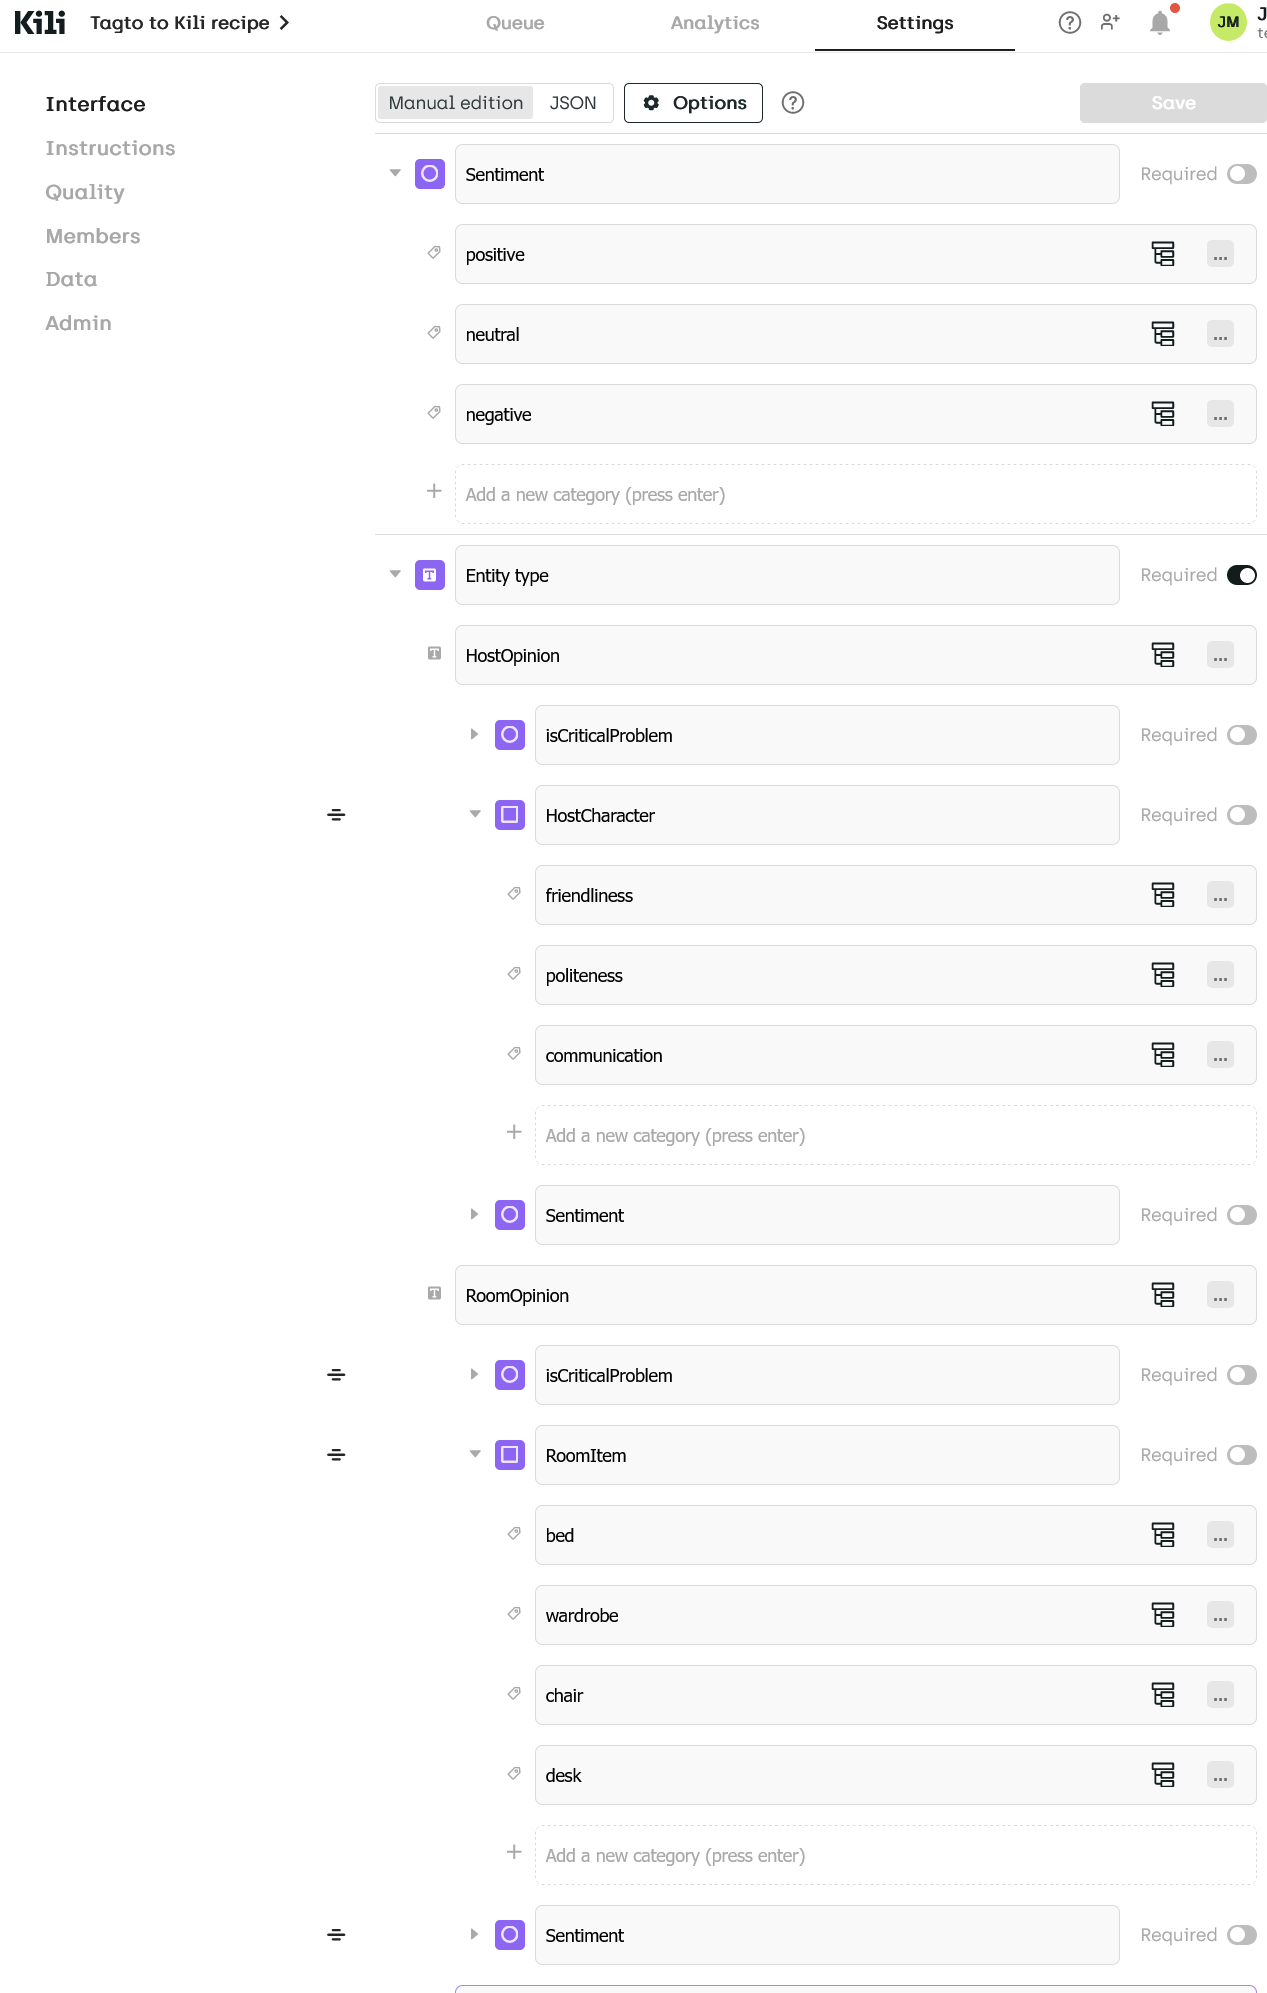

## Upload assets

Now that the project is created, we can upload our assets.

In [ ]:
filepaths = [
    Path("ApartmentReviews/plain.html/pool/") / filepath
    for filepath in os.listdir("ApartmentReviews/plain.html/pool/")
]
print(len(filepaths))

228


In [ ]:
external_ids = [filepath.name.replace(".plain.html", "") for filepath in filepaths]
assets = [
    BeautifulSoup(file.read_text(encoding="utf-8"), "html.parser").find("body").get_text().strip()
    for file in filepaths
]

In [ ]:
print(external_ids[0])
print(assets[0])

aKRwFKFHhO5FoLBBCEUJl8gkQoBS-text
Jason was great! He welcomed us with cold waters and fully explained the apartment and its many amenities. He provided anything we could have forgotten and made sure to answer the many questions we had. He was quick to answer any additional questions throughout the stay as well. The apartment is located on a quiet hutong right off a main street that is right in the center of the old town and is just a short walk to the metro. The shower is a bit hard to get in and out of, and would be difficult if you have mobility issues. But the apartment was great and we really enjoyed a little bit of local living while in Beijing. Thanks Jason!


In [ ]:
kili.append_many_to_dataset(project_id, content_array=assets, external_id_array=external_ids)

Our assets have been successfully uploaded to Kili:

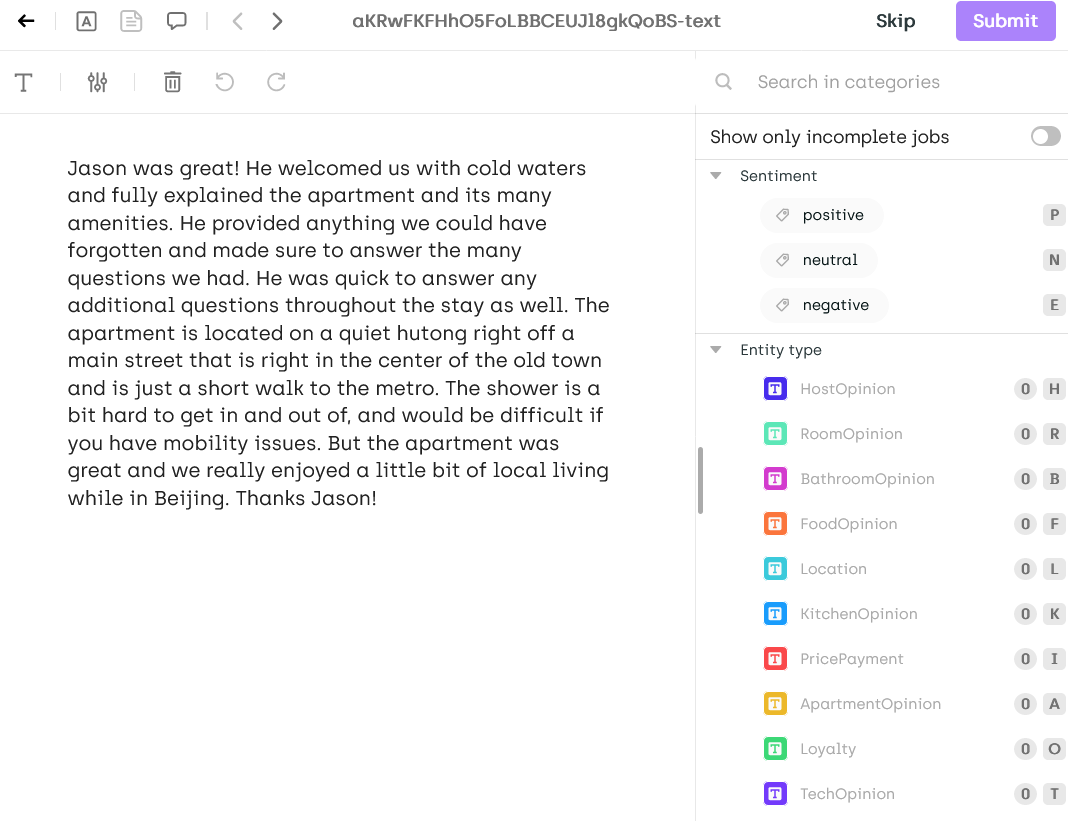

## Upload existing annotations

Now that our project is created with its assets, we can upload the annotations we made in tagtog.

But first we need to convert the tagtog annotations to the Kili format.

In [ ]:
json_response_array = []

for asset_name, asset in zip(external_ids, assets):
    # load the tagtog json annotation
    annotation_path = Path("ApartmentReviews/ann.json/master/pool/") / (asset_name + ".ann.json")
    tagtog_annotation = json.loads(annotation_path.read_text(encoding="utf-8"))

    # skip if not annotated
    if not tagtog_annotation["anncomplete"]:
        continue

    # kili json response
    json_response = {}

    # overall review sentiment classification
    try:
        sentiment_class = tagtog_annotation["metas"]["m_18"]["value"]
    except KeyError:
        pass  # the asset is not annotated for sentiment
    else:
        assert sentiment_class in ("positive", "negative", "neutral"), sentiment_class
        sentiment_confidence = int(
            round(tagtog_annotation["metas"]["m_18"]["confidence"]["prob"] * 100)
        )

        # we add the sentiment classification to the json response
        json_response["SENTIMENT_CLASSIFICATION_JOB"] = {}
        json_response["SENTIMENT_CLASSIFICATION_JOB"]["categories"] = [
            {"name": sentiment_class, "confidence": sentiment_confidence}
        ]

    # we skip assets with complex html for the sake of clarity
    if len(tagtog_annotation["annotatable"]["parts"]) > 1:
        json_response_array.append(json_response)
        continue

    # Named entities recognition job
    json_response["NAMED_ENTITIES_RECOGNITION_JOB"] = {"annotations": []}
    for entity in tagtog_annotation["entities"]:
        ner_class = tagtog_class_id_to_class_name[entity["classId"]]

        # make sure the class is in the json interface
        assert (
            ner_class
            in json_interface["jobs"]["NAMED_ENTITIES_RECOGNITION_JOB"]["content"]["categories"]
        ), ner_class

        confidence = int(round(entity["confidence"]["prob"] * 100))

        # get the begin offset and the content of the entity
        assert len(entity["offsets"]) == 1, entity["offsets"]
        begin_offset = entity["offsets"][0]["start"]
        content = entity["offsets"][0]["text"]

        # we verify that the content and begin_offset match the asset content
        assert content == asset[begin_offset : begin_offset + len(content)], (
            content,
            asset[begin_offset : begin_offset + len(content)],
        )

        entity_annotation = {
            "children": {},
            "beginOffset": begin_offset,
            "categories": [{"name": ner_class, "confidence": confidence}],
            "content": content,
        }

        # an named entity can have tagtog entity labels
        # we convert them to Kili children annotations
        for field_id in entity["fields"]:
            entity_label = tagtog_class_id_to_class_name[field_id]
            job_interface = json_interface["jobs"][entity_label]
            confidence = int(round(entity["fields"][field_id]["confidence"]["prob"] * 100))
            label_class = entity["fields"][field_id]["value"]

            # we convert boolean fields to match our json interface
            if entity_label == "isLocationQuiet":
                label_class = "Quiet" if label_class else "Noisy"

            if entity_label == "isCriticalProblem":
                label_class = "yes" if label_class else "no"

            if entity_label == "HostCharacter" and label_class == "friendly":
                label_class = "friendliness"

            # some job names have spaces that we converted to "_" in our json interface
            label_class = label_class.replace(" ", "_")
            assert label_class in job_interface["content"]["categories"], f"{label_class} {entity}"

            if entity_label not in entity_annotation["children"]:
                entity_annotation["children"][entity_label] = {"categories": []}

            # we add the child annotations to the NER annotation
            entity_annotation["children"][entity_label]["categories"].append(
                {"name": label_class, "confidence": confidence}
            )

        json_response["NAMED_ENTITIES_RECOGNITION_JOB"]["annotations"].append(entity_annotation)

    json_response_array.append(json_response)

We can now upload the Kili annotations to our project:

In [ ]:
kili.append_labels(
    json_response_array=json_response_array,
    project_id=project_id,
    asset_external_id_array=external_ids,
)

We can see that this asset's labels in tagtog labeling interface:

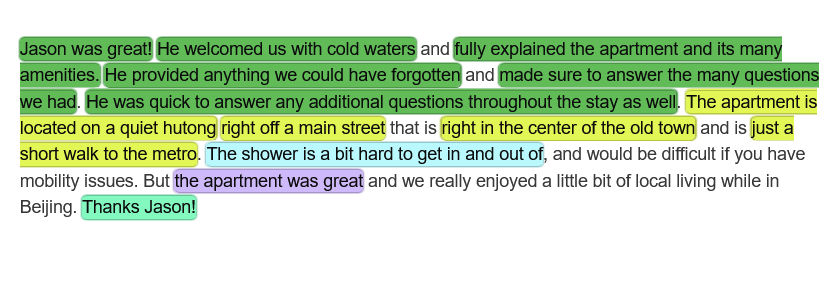

match the Kili labels we converted previously:

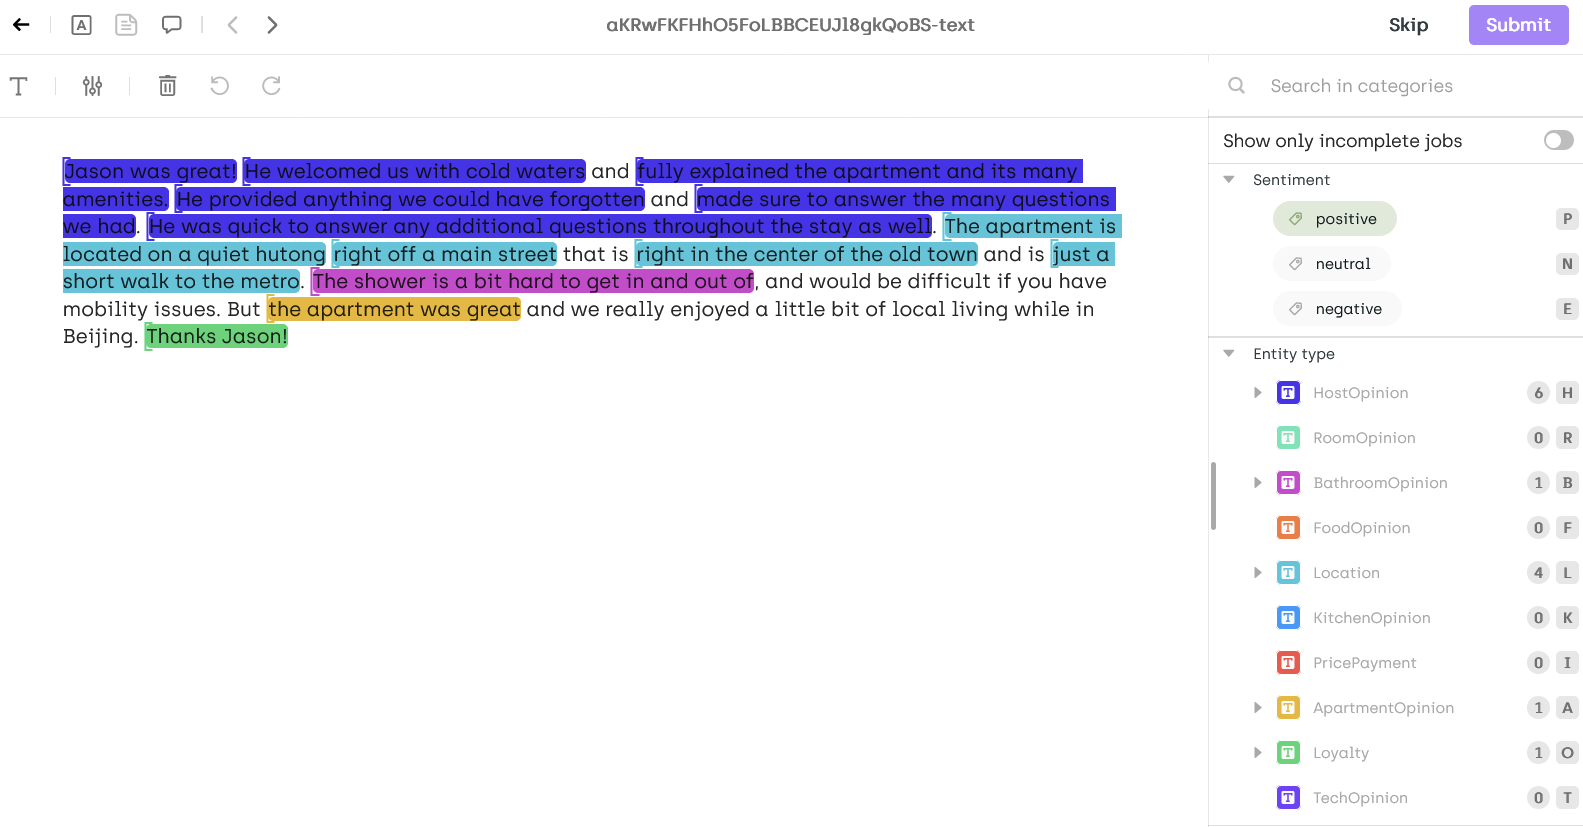

We also see that the entity labels (child annotations in Kili) are shown in the labeling interface:

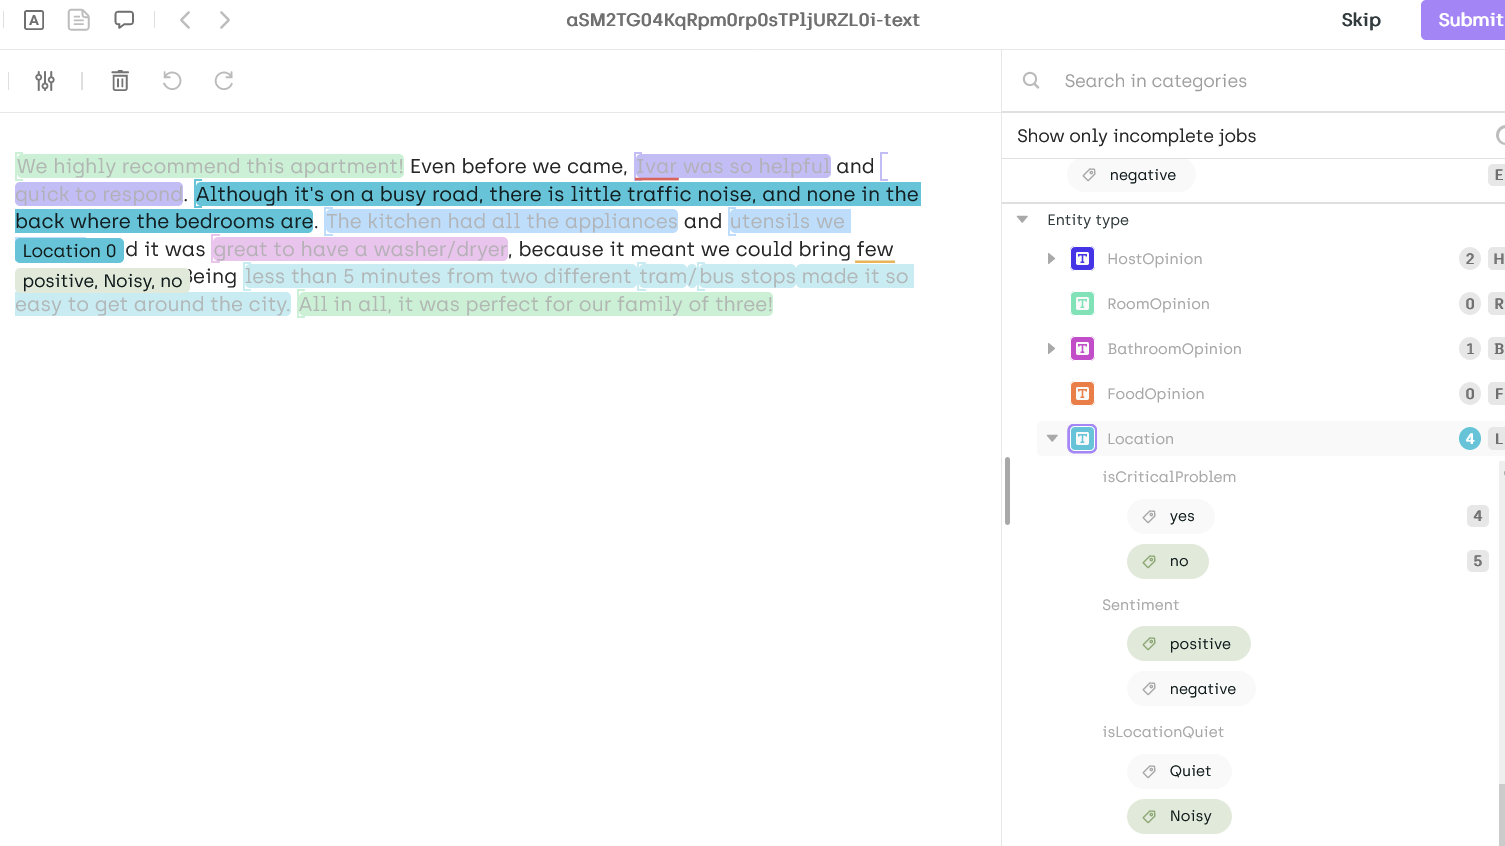

## Conclusion

In this recipe, we saw how to convert a tagtog project to Kili.

As you can see, the Kili json interface and the json response formats are really flexible and can be adapted to a lot of use cases.

## Project cleanup

In [ ]:
kili.delete_project(project_id)